In [ ]:
!pip install albumentations
!pip install opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# data processing
import os
import gc
import cv2
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")
import keras
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

## 1. Подготовка данных 

In [29]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: длина пробега в виде строки (начальная длина)
    форма: (высота,ширина) возвращаемого массива 
    Возвращает массив numpy, 1 - маска, 0 - фон
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape)
    return img

In [30]:
df = pd.read_csv('/content/drive/MyDrive/input/train_masks.csv')
print(f'Data shape: {df.shape}')
df.head()

Data shape: (5088, 2)


,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [31]:
# создаем набор данных train/val
all_id = np.array(range(df.shape[0]), dtype=np.uint8)
np.random.seed(42)
np.random.shuffle(all_id)
split_size = 0.8
train_df = df.loc[all_id[:int(df.shape[0] *split_size)]]
val_df = df.loc[all_id[int(df.shape[0] * split_size):]]
print(f'Train DataFrame shape: {train_df.shape}\n'
     f'Validation DataFrame shape: {val_df.shape}')

Train DataFrame shape: (4070, 2)
Validation DataFrame shape: (1018, 2)


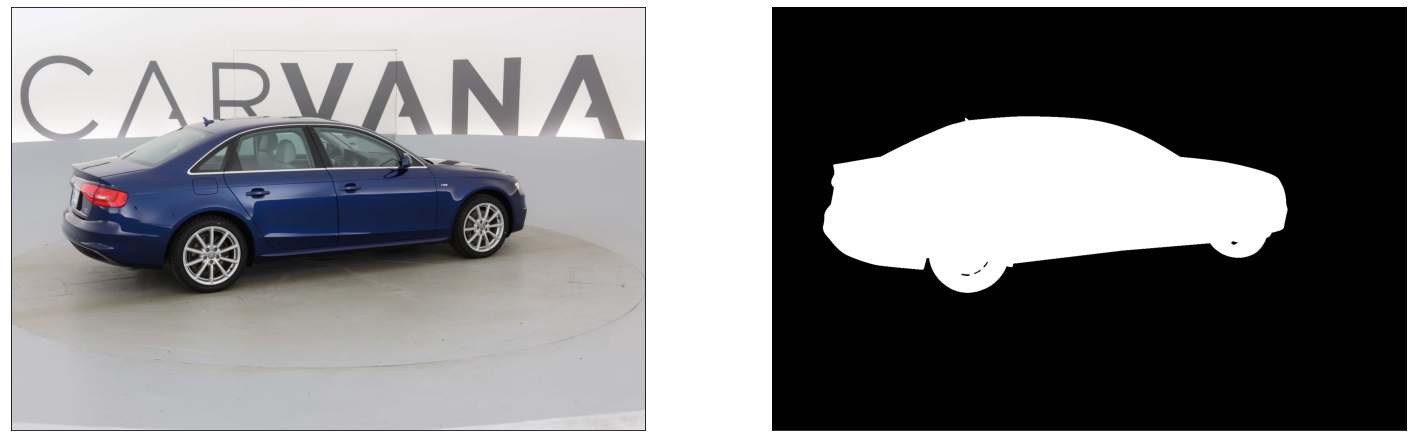

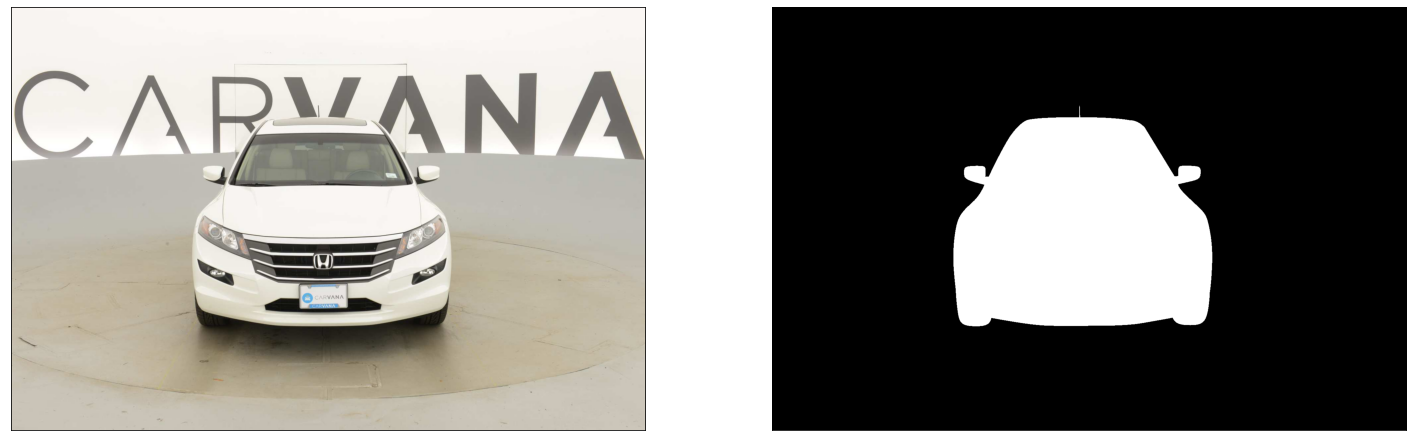

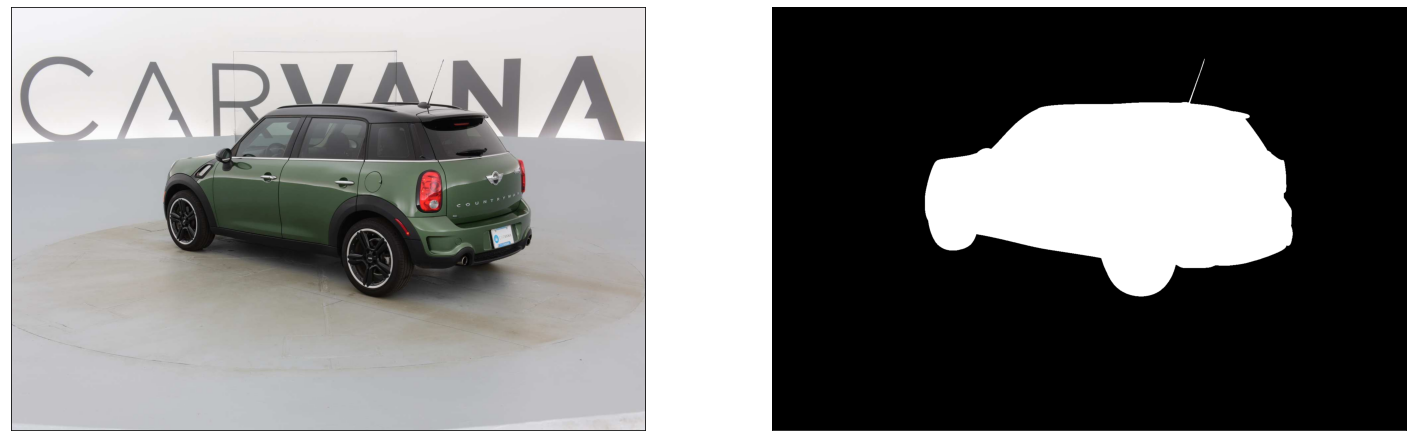

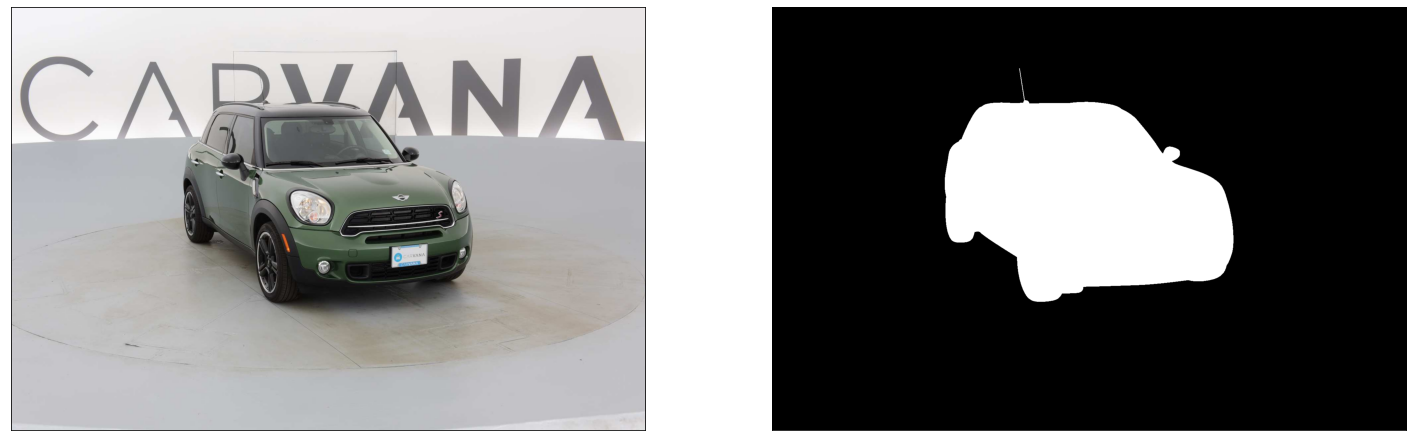

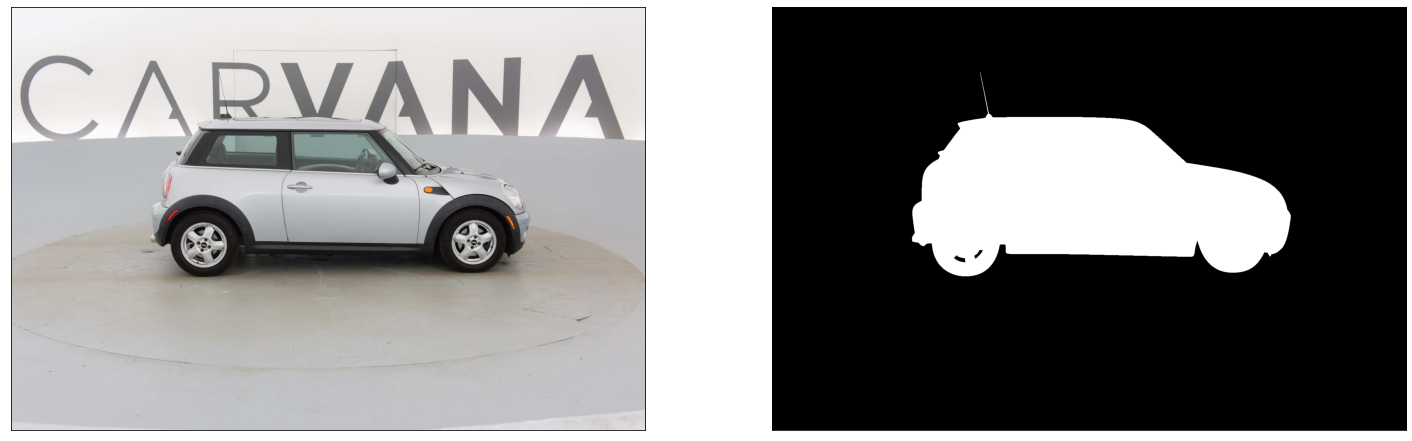

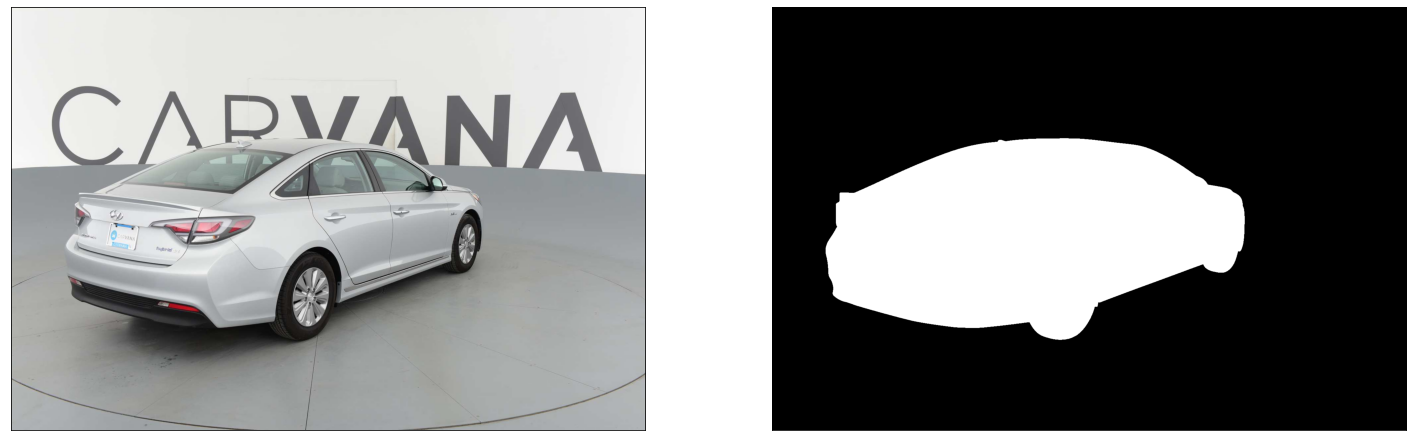

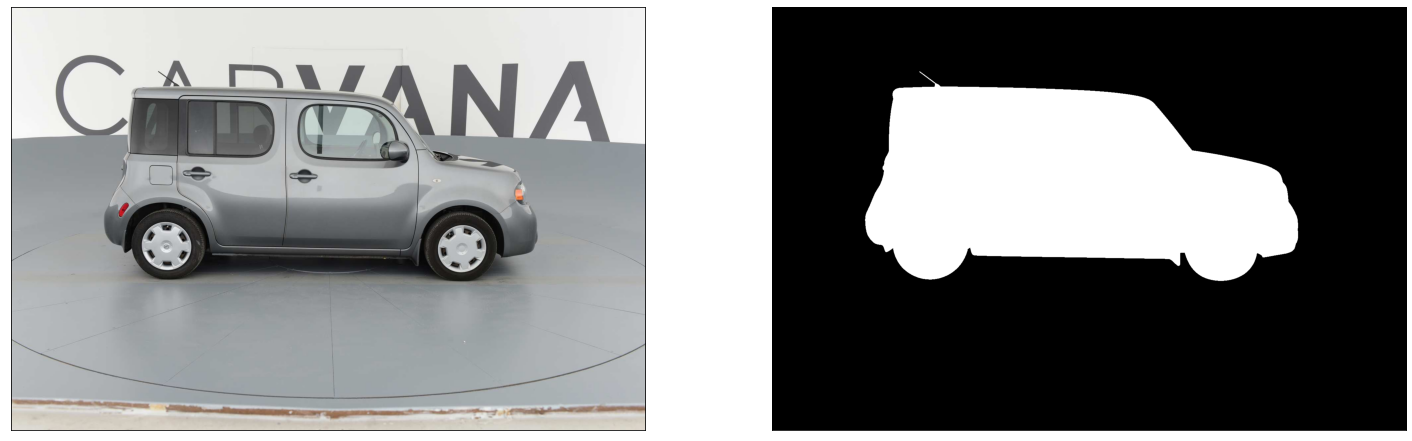

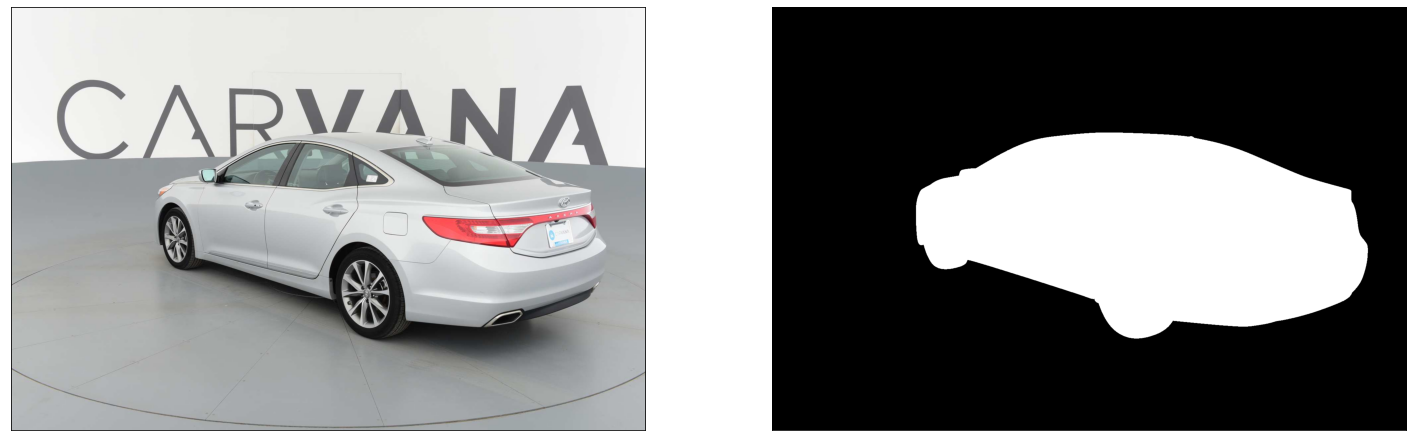

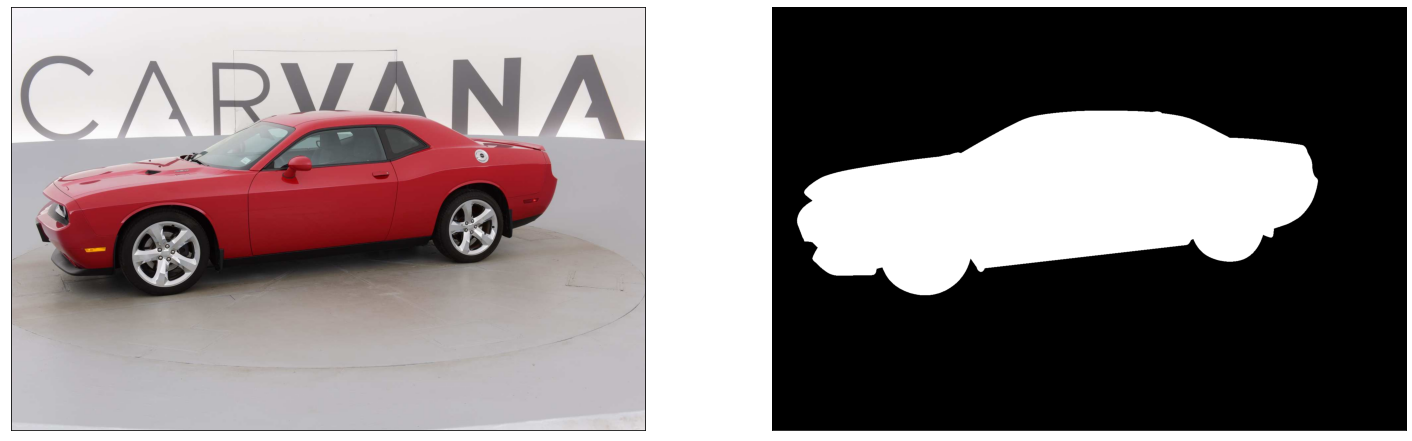

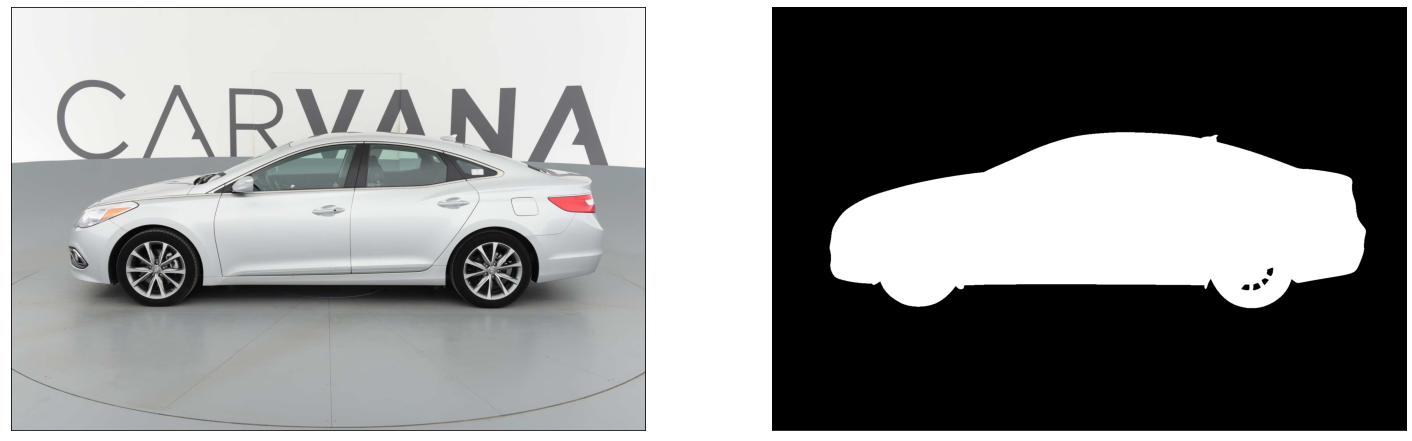

In [32]:
ex_num = 10
random_id = np.random.choice(train_df.shape[0], size=ex_num, replace=False)
for i, row_id in enumerate(random_id):
    img_name, mask_rle = train_df.iloc[row_id]
    img = cv2.imread('/content/drive/MyDrive/input/train/{}'.format(img_name))
    w, h, _ = img.shape
    mask = rle_decode(mask_rle, shape=(w, h, 1))
    # изменить цветовое пространство для plt
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
    axes[1].imshow(mask[..., 0], cmap='gray')
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### Train genrator 

In [33]:
def keras_generator(gen_df, batch_size, preprocess_input=None):
    while True:
        x_batch = []
        y_batch = []
        random_id = np.random.choice(gen_df.shape[0], size=batch_size, replace=False)
        for row_id in random_id:
            img_name, mask_rle = gen_df.iloc[row_id]
            img = cv2.imread('/content/drive/MyDrive/input/train/{}'.format(img_name))
            w, h, _ = img.shape
            mask = rle_decode(mask_rle, shape=(w, h, 1))

            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            x_batch += [img]
            y_batch += [mask]


        x_batch = np.array(x_batch) / 255.  # normalize
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [34]:
# тестируем
train_gen = keras_generator(train_df, 10)
x, y = next(iter(train_gen))
print(f'Input size: {x.shape}\n'
     f'Output size: {y.shape}')

Input size: (10, 256, 256, 3)
Output size: (10, 256, 256, 1)


## SegNet



In [35]:
inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)
conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)
conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)
conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)
conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)

result = Activation('sigmoid')(conv_up_4_2)
segnet_model = Model(inputs=inp, outputs=result)

In [43]:
from tensorflow import keras

In [45]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)
callbacks = [best_w, last_w]
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
segnet_model.compile(adam, 'binary_crossentropy')

In [46]:
segnet_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
activation_67 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
activation_68 (Activation)   (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 128, 128, 64)      1849

In [48]:
batch_size = 4
train_gen = keras_generator(train_df, batch_size)
val_gen = keras_generator(val_df, batch_size)
hist = segnet_model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=5,
    callbacks=callbacks,
    validation_data=val_gen,
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0,
    verbose=1,)

Epoch 1/5
100/100 [==============================] - 690s 7s/step - loss: 0.3495 - val_loss: 0.2057
Epoch 2/5
100/100 [==============================] - 686s 7s/step - loss: 0.1348 - val_loss: 0.0800
Epoch 3/5
100/100 [==============================] - 686s 7s/step - loss: 0.0714 - val_loss: 0.0678
Epoch 4/5
100/100 [==============================] - 685s 7s/step - loss: 0.0568 - val_loss: 0.0659
Epoch 5/5
100/100 [==============================] - 684s 7s/step - loss: 0.0464 - val_loss: 0.0376


In [51]:
pred = segnet_model.predict(x)

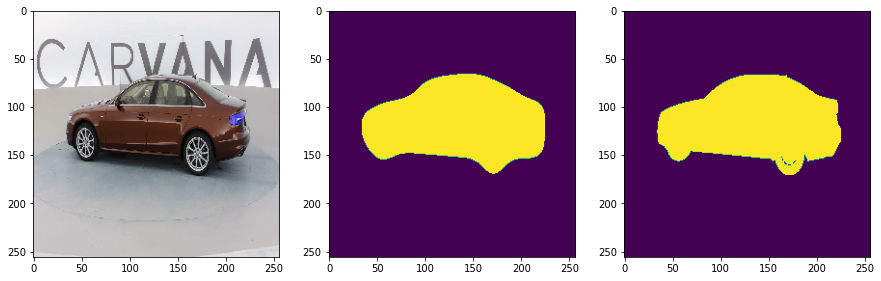

In [52]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)
axes[2].imshow(y[im_id, ..., 0])
plt.show()

In [56]:
pred_mask=(pred[im_id, ..., 0] > 0.5)*1

In [57]:
mask=(y[im_id, ..., 0])

In [58]:
def IoU(mask, pred_mask):
    iou = np.sum(mask * pred_mask)/np.sum(mask + pred_mask)
    return print(iou)

In [59]:
IoU(mask, pred_mask)

0.4898404019506428


In [60]:
def dice(mask, pred_mask):
    dice=(2*np.sum(mask * pred_mask))/(np.sum(mask) + np.sum(pred_mask))
    return print(dice)

In [61]:
dice(mask, pred_mask)

0.9796808039012856


## Vanila UNet


In [54]:
#from keras.models import Model
#from keras.layers import Input, Dense, Concatenate
#from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)


conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)


up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)



up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)


unet_model = Model(inputs=inp, outputs=result)

adam = keras.optimizers.Adam(lr=0.1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
unet_model.compile(adam, 'binary_crossentropy')

In [55]:
batch_size = 4
train_gen = keras_generator(train_df, batch_size)
val_gen = keras_generator(val_df, batch_size)
hist = unet_model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=5,
    callbacks=callbacks,
    validation_data=val_gen,
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0,
    verbose=1,)

Epoch 1/5
100/100 [==============================] - 859s 9s/step - loss: 0.5625 - val_loss: 0.4637
Epoch 2/5
100/100 [==============================] - 858s 9s/step - loss: 0.3749 - val_loss: 0.2805
Epoch 3/5
100/100 [==============================] - 856s 9s/step - loss: 0.2370 - val_loss: 0.2133
Epoch 4/5
100/100 [==============================] - 856s 9s/step - loss: 0.2006 - val_loss: 0.2171
Epoch 5/5
100/100 [==============================] - 856s 9s/step - loss: 0.1645 - val_loss: 0.1552


In [62]:
pred2 = unet_model.predict(x)

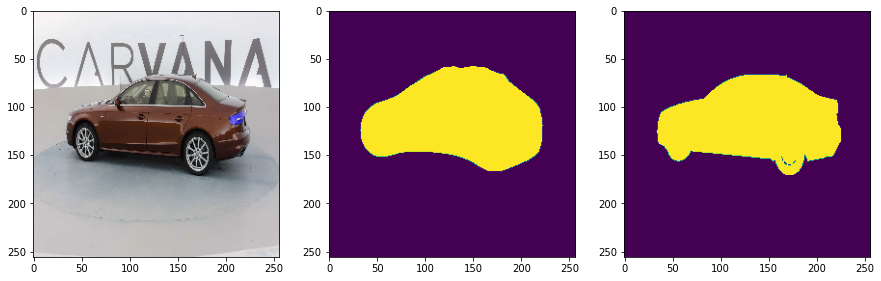

In [63]:
im_id = 0
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred2[im_id, ..., 0] > 0.5)
axes[2].imshow(y[im_id, ..., 0])
plt.show()

In [64]:
pred_mask2=(pred2[im_id, ..., 0] > 0.5)*1

In [65]:
mask2=(y[im_id, ..., 0])

In [66]:
IoU(mask2, pred_mask2)

0.4665047850307099


In [67]:
dice(mask2, pred_mask2)

0.9330095700614198
